<a href="https://colab.research.google.com/github/Nikhil-Nandam/TensorFlow-Notebooks/blob/main/09_SkimLit_NLP_Milestone_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit 📄🔥

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arvix.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arvix.org/abs/1612.05251

## Confirm access to a GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e735a1de-6946-aba8-99b4-36b297336e63)


## Get data

Since we'll be replicating the paper above (200k RCT), let's download the dataset they've used.

We can do so from the authors' GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# Start our experiments using the 20k dataset with numbers replaced with '@' sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with tha data is to...

> Visualize, visualize, visualize

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [6]:
# Create a function to read the lines of a document
def get_lines(filename):
    """
    Reads filename (a text filename) and returns the lines of text as a list.

    Args:
        filename: a string containing the target filepath.

    Returns:
        A list of strings with one string per line from the target filename.
    """

    with open(filename, "r") as file:
        return file.readlines()

In [7]:
# Let's read in the training lines
train_lines = get_lines(data_dir + "train.txt") # read the lines within the training file
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Let's think about how we want our data to look..

How I think our data would be best represented...

```
[{"line_number": 0,
   "target": "BACKGROUND",
   "text": "Emotional eating is associated with overeating and the development of obesity .\n",
   "total_lines": 11},
   ...]
```

In [8]:
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries of abstract line data.

    Args:
        filename: Reads it's contents and sorts through each line,
                  extracting things like target label, the text of the sentence,
                  how many sentences are in the current abstract and what sentence
                  number the target line is.

    """
    input_lines = get_lines(filename)   # get all lines from filename
    abstract_lines = "" # create an empty abstract
    abstract_samples = []   # create an empty list of abstracts

    # Loop through each line in the target file
    for line in input_lines:
        if line.startswith("###"):  # check to see if the line is an ID line
            abstract_id = line
            abstract_lines = "" # reset the abstract string if the line is an ID line
        elif line.isspace():    # check to see if line is a new line
            abstract_line_split = abstract_lines.splitlines()   # split abstract into separate lines

            # Iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}  # create an empty dictionary for each line
                target_text_split = abstract_line.split("\t")   # split target label from text
                line_data["target"] = target_text_split[0]  # get the target label from text
                line_data["text"] = target_text_split[1].lower()    # get target text and lower it
                line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract
                line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
                abstract_samples.append(line_data)  # add line data to abstract samples list

        else:   # if the above conditions aren't fulfilled, the line contains a labelled sentence
            abstract_lines += line

    return abstract_samples

In [9]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 613 ms, sys: 117 ms, total: 729 ms
Wall time: 829 ms


In [10]:
# Check the first abstract of our training data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data is the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it?

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [12]:
# Distribution of labels in training data
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

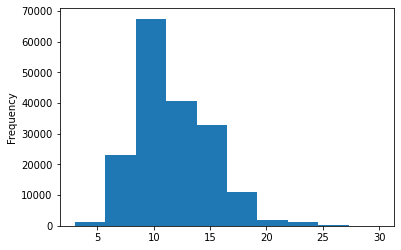

In [13]:
# Let's check the length of different lines
train_df["total_lines"].plot.hist();

### Get list of sentences

In [14]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [15]:
# View the first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [16]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [17]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [18]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments...

As usual, we're going to be trying out a bunch of different models and seeing which one works best.
And as always, we're going to start with a baseline (TF-IDF Multinomial Naïve Bayes classifier).

## Model 0: Getting a baseline

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [20]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [21]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script

Download helper function script to import a function that helps us compare our model's predictions across different metrics (accuracy, precision, recall, f1-score) rather than rewriting it here.

Find it [here](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py).

In [22]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-21 14:00:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-21 14:00:40 (62.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [23]:
from helper_functions import calculate_results

# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

### Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [25]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_length = np.mean(sent_lens)
avg_sent_length

26.338269273494777

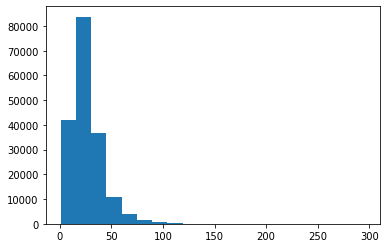

In [26]:
# How does the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [27]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [28]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our words to numbers.

In [29]:
# How many words are in our vocabulary? (taken from table 2 in: https://arxiv.orf/pdf/1710.06071.pdf)
max_tokens = 68000

In [30]:
# Create a text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,  # number of words in vocab
                                    output_sequence_length=output_seq_len)  # desired output length of vectorized sequences

In [31]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [32]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
thus , in addition to the eight patients who were randomly assigned to receive bevacizumab plus lomustine @ mg/m ( @ ) , @ patients were assigned to receive bevacizumab alone , @ to receive lomustine alone , and @ to receive bevacizumab plus lomustine @ mg/m ( @ ) .

Length of text: 51

Vectorized text: [[ 927    5  333    6    2  760   12   67    9   92  123    6  175 1034
   231 8237 1002   12    9  123    6  175 1034  271    6  175 8237  271
     3    6  175 1034  231 8237 1002    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [33]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [34]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Create custom text embedding

In [35]:
# Create token embedding layer
from tensorflow.keras.layers import Embedding

token_embed = Embedding(input_dim=len(rct_20k_text_vocab),  # length of vocabulary
                        output_dim=128, # Note: different embedding sizes result in drastically different number of parameters to train
                        mask_zero=True, # use masking to handle variable sequence length
                        name="token_embedding")

In [36]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
print(f"Vectorized sentence shape:{vectorized_sentence.shape}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape:{embedded_sentence.shape}")

Sentence before vectorization:
thus , in addition to the eight patients who were randomly assigned to receive bevacizumab plus lomustine @ mg/m ( @ ) , @ patients were assigned to receive bevacizumab alone , @ to receive lomustine alone , and @ to receive bevacizumab plus lomustine @ mg/m ( @ ) .

Sentence after vectorization (before embedding):
[[ 927    5  333    6    2  760   12   67    9   92  123    6  175 1034
   231 8237 1002   12    9  123    6  175 1034  271    6  175 8237  271
     3    6  175 1034  231 8237 1002    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Vectorized sentence shape:(1, 55)

Sentence after embedding:
[[[-0.03699286  0.03111063  0.02621717 ... -0.02169942  0.02934423
   -0.00242453]
  [ 0.02616239  0.01219917 -0.03690442 ... -0.00873327  0.00175873
    0.00791792]
  [-0.02933835 -0.01534874  0.02619925 ...  0.0322012   0.02813971
    0.02231664]
  ...
  [-0.03834748 -0.03741177  0.00186651 ...  0.0178

### Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two resources:
* [Data_Performance](https://www.tensorflow.org/guide/data_performance)
* [Input_Pipelines](https://www.tensorflow.org/guide/data)

In [37]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [38]:
# Take the TensorSliceDatasets and prefetch them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [39]:
# Create Conv1D model to process sequences
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPool1D, Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

inputs = Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)  # vectorize text inputs
token_embeddings = token_embed(text_vectors)    # create embedding
x = Conv1D(64, 5, padding="same", activation="relu")(token_embeddings)
x = GlobalMaxPool1D()(x) # condense the output of our feature vector from conv layer
outputs = Dense(num_classes, activation="softmax")(x)
model_1 = Model(inputs, outputs)

In [40]:
# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [41]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 325   

In [42]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                            #   steps_per_epoch=len(train_dataset),
                              epochs=5,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/5
562/562 [==============================] - 17s 9ms/step - loss: 0.8479 - accuracy: 0.6772 - val_loss: 0.5880 - val_accuracy: 0.7889
Epoch 2/5
562/562 [==============================] - 5s 8ms/step - loss: 0.5812 - accuracy: 0.7870 - val_loss: 0.5382 - val_accuracy: 0.8009
Epoch 3/5
562/562 [==============================] - 5s 8ms/step - loss: 0.5435 - accuracy: 0.8010 - val_loss: 0.5225 - val_accuracy: 0.8065
Epoch 4/5
562/562 [==============================] - 5s 8ms/step - loss: 0.5245 - accuracy: 0.8072 - val_loss: 0.5251 - val_accuracy: 0.8032
Epoch 5/5
562/562 [==============================] - 5s 8ms/step - loss: 0.5293 - accuracy: 0.8057 - val_loss: 0.4960 - val_accuracy: 0.8152


In [43]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.4944 - accuracy: 0.8196


[0.4943997263908386, 0.8195750117301941]

In [44]:
# Make predictions (our model predicts prediction probability for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[6.5676618e-01, 1.7348722e-01, 1.7231471e-03, 1.4752536e-01,
         2.0498075e-02],
        [4.1007781e-01, 4.0154535e-01, 2.8270222e-02, 1.0884629e-01,
         5.1260311e-02],
        [3.7961623e-01, 2.7897239e-02, 1.8514087e-02, 5.7333970e-01,
         6.3277798e-04],
        ...,
        [2.0698358e-04, 1.2519289e-03, 1.1854021e-02, 1.3522478e-04,
         9.8655188e-01],
        [1.5277967e-02, 6.2950885e-01, 1.5764035e-02, 6.7974152e-03,
         3.3265167e-01],
        [8.4734038e-02, 8.9317697e-01, 1.5918592e-02, 2.2734343e-03,
         3.8970008e-03]], dtype=float32), (30212, 5))

In [45]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [46]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 81.9575003309943,
 'f1': 0.8173750476821274,
 'precision': 0.8211386087907235,
 'recall': 0.819575003309943}

## Model 2: Feature Extraction with Pretrained Token Embeddings

Now let's use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder (USE): [Universal-Sentence-Encoder](https://tfhub.dev/google/universal-sentence-encoder/4)

The paper originally used GloVe embeddings, however, we're going to stick with the later creates USE pretrained embeddings.

In [47]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [48]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n{random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
when hyperglycemia was accompanied by hyperinsulinemia or by the simultaneous infusion of glp-@ , these phenomena were attenuated .
Sentence after embedding:
[ 0.03931776  0.06214483  0.03538927  0.01771118 -0.02277842  0.04651004
  0.04310166 -0.03936665 -0.05088084  0.07089143  0.08264481  0.02434804
  0.06532153  0.04273726 -0.04083353 -0.03636762 -0.07332754  0.01441509
  0.04074648  0.04903762  0.09361144 -0.01397917 -0.01961607  0.02856367
 -0.00148629  0.06835493  0.01121286 -0.01796325 -0.07189404  0.03575417]

Length of sentence embedding: 512


### Building and fitting an NLP Feature Extraction model using Pretrained Embeddings from TensorFlow Hub

In [49]:
# Define feature extraction model using
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

inputs = Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)   # tokenize text and create embedding of each sequence (512 long vector)
x = Dense(128, activation="relu")(pretrained_embedding)
# Note: you could add more layers here if you want to
outputs = layers.Dense(num_classes, activation="softmax")(x)  # create the output layers
model_2 = Model(inputs, outputs, name="model_2_USE_feature_extractor")

In [50]:
# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [51]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [52]:
# Fit the model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                            #   steps_per_epoch=len(train_dataset),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/5
562/562 [==============================] - 9s 12ms/step - loss: 0.9152 - accuracy: 0.6496 - val_loss: 0.7991 - val_accuracy: 0.6878
Epoch 2/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7702 - accuracy: 0.7001 - val_loss: 0.7566 - val_accuracy: 0.7035
Epoch 3/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7547 - accuracy: 0.7117 - val_loss: 0.7418 - val_accuracy: 0.7161
Epoch 4/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7211 - accuracy: 0.7231 - val_loss: 0.7144 - val_accuracy: 0.7247
Epoch 5/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7281 - accuracy: 0.7200 - val_loss: 0.6946 - val_accuracy: 0.7311


In [53]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 9s 10ms/step - loss: 0.6999 - accuracy: 0.7338


[0.6998910903930664, 0.7338474988937378]

In [54]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[6.2181652e-01, 2.6096448e-01, 3.2143551e-03, 1.0135396e-01,
        1.2650637e-02],
       [4.6061990e-01, 4.4445780e-01, 8.8202041e-03, 8.3502211e-02,
        2.5998864e-03],
       [3.5539821e-01, 8.5344665e-02, 4.9328428e-02, 4.6334141e-01,
        4.6587341e-02],
       ...,
       [2.2315942e-03, 2.1389518e-03, 8.2354426e-02, 7.6222466e-04,
        9.1251284e-01],
       [2.6601956e-03, 2.3132270e-02, 4.5979550e-01, 9.4023085e-04,
        5.1347184e-01],
       [1.3935766e-01, 3.9006656e-01, 4.1733018e-01, 2.3418320e-03,
        5.0903697e-02]], dtype=float32)

In [55]:
# Convert the prediction probabilities found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 2])>

In [56]:
# Calculate results from TF Hub Pretrained Embedding on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 73.38474778233814,
 'f1': 0.7280745036464269,
 'precision': 0.7295884339278865,
 'recall': 0.7338474778233814}

## Model 3: Character Embeddings

The paper which we're replicating used a combination of token and character-level embeddings.

Previously we've used token-level embeddings but we'll need to do similar steps for characters if we want to use character-level embeddings.

### Creating a character-level tokenizer

In [57]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [58]:
# Make function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

# Test splitting a non-character-level sequence into characters
split_chars(random_train_sentence)

'w h e n   h y p e r g l y c e m i a   w a s   a c c o m p a n i e d   b y   h y p e r i n s u l i n e m i a   o r   b y   t h e   s i m u l t a n e o u s   i n f u s i o n   o f   g l p - @   ,   t h e s e   p h e n o m e n a   w e r e   a t t e n u a t e d   .'

In [59]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [60]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

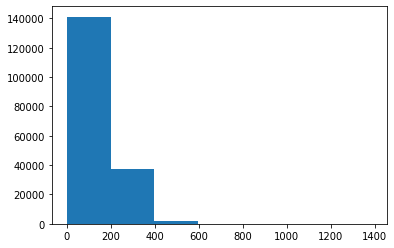

In [61]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [62]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [63]:
# Get all keyboard characters
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [64]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    # standardize=None, # set standarization to "None" if you want to leave punctuation on
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [65]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [66]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [67]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
@   p a t i e n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   c h e m o t h e r a p y   a n d   @   t o   e r l o t i n i b   ,   a n d   @   (   @   %   )   a n d   @   (   @   %   )   ,   r e s p e c t i v e l y   ,   w e r e   i n c l u d e d   i n   t h e   p e r - p r o t o c o l   a n a l y s i s   .

Length of random_train_chars: 127

Vectorized chars:
[[14  5  3  4  2  6  3  9 20  2  8  2  8  5  6 10  7 15 12 19  5  9  9  4
  18  6  2 10  3  7 11 13  2 15  7  3 13  2  8  5 14 19  5  6 10  3  7  2
   8 12  7  3  4  6  4 22  5  6 10  5  6 10  8  2  9 14  2 11  3  4 21  2
  12 19 20  2  8  2  4  6 11 12 16 10  2 10  4  6  3 13  2 14  2  8 14  8
   7  3  7 11  7 12  5  6  5 12 19  9  4  9  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  

### Creating a character-level embedding

In [68]:
# Create char embedding layer
char_embed = Embedding(input_dim=len(char_vocab),   # number of different characters
                       output_dim=25,   # this is the size of char emebedding in the paper: https://arvix.org/pdf/1612.05251.pdf (Figure 1)
                       mask_zero=True,
                       name="char_embed")

In [69]:
# Test out character embedding layer
print(f"Charified text:\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
@   p a t i e n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   c h e m o t h e r a p y   a n d   @   t o   e r l o t i n i b   ,   a n d   @   (   @   %   )   a n d   @   (   @   %   )   ,   r e s p e c t i v e l y   ,   w e r e   i n c l u d e d   i n   t h e   p e r - p r o t o c o l   a n a l y s i s   .

Embedded chars (after vectorization and embedding):
[[[ 0.0397452   0.02474293  0.04244801 ... -0.00214366 -0.00390029
   -0.0219765 ]
  [ 0.02499713 -0.0471247  -0.01402118 ... -0.0399677  -0.02353072
   -0.013046  ]
  [-0.00861286 -0.03028414  0.03723362 ...  0.03315279 -0.03557168
    0.00030883]
  ...
  [-0.00037599 -0.02883815  0.00523136 ...  0.01616937  0.04545407
    0.02181095]
  [-0.00037599 -0.02883815  0.00523136 ...  0.01616937  0.04545407
    0.02181095]
  [-0.00037599 -0.02883815  0.00523136 ...  0.01616937  0.04545407
    0.02181095]]]

Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [70]:
# Make Conv1D on chars only
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPool1D, Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

inputs = Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = Conv1D(64, 5, padding="same", activation="relu")(char_embeddings)
x = GlobalMaxPool1D()(x)
outputs = Dense(num_classes, activation="softmax")(x)
model_3 = Model(inputs, outputs, name="model_3_conv1d_char_embeddings")

In [71]:
# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [72]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 

In [73]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [74]:
# Fit the model on chars only
history_model_3 = model_3.fit(train_char_dataset,
                              epochs=5,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                            #   steps_per_epoch=len(train_dataset),
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/5
562/562 [==============================] - 4s 6ms/step - loss: 1.2723 - accuracy: 0.4779 - val_loss: 1.0418 - val_accuracy: 0.5894
Epoch 2/5
562/562 [==============================] - 3s 5ms/step - loss: 1.0025 - accuracy: 0.5999 - val_loss: 0.9364 - val_accuracy: 0.6366
Epoch 3/5
562/562 [==============================] - 3s 5ms/step - loss: 0.9209 - accuracy: 0.6422 - val_loss: 0.8659 - val_accuracy: 0.6682
Epoch 4/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8657 - accuracy: 0.6689 - val_loss: 0.8380 - val_accuracy: 0.6752
Epoch 5/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8543 - accuracy: 0.6668 - val_loss: 0.8109 - val_accuracy: 0.6799


In [75]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.31626838, 0.48126817, 0.05840373, 0.136972  , 0.00708769],
       [0.25844157, 0.51200414, 0.01011169, 0.2102765 , 0.00916614],
       [0.10573781, 0.29465282, 0.36446956, 0.1429779 , 0.09216189],
       ...,
       [0.0299216 , 0.04666788, 0.1928759 , 0.03742513, 0.69310945],
       [0.055434  , 0.25931695, 0.31922916, 0.0557473 , 0.31027257],
       [0.19943532, 0.6661533 , 0.11634061, 0.01075397, 0.00731681]],
      dtype=float32)

In [76]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 2, 1])>

In [77]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 67.93327154772938,
 'f1': 0.6767039902953516,
 'precision': 0.6853145600178141,
 'recall': 0.6793327154772938}

## Model 4: Combining Pretrained Token Embeddings + Characters Embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar to `model_2`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers of top of 3 (similar to Figure 1 of section 4.2 of https://arxiv.org/pdf/1612.05251.pdf)
5. Construct a model which takes a token and character-level sequences as input and produces sequence label probabilities as output

In [78]:
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Concatenate, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

# 1. Setup token inputs/model
token_inputs = Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = Dense(128, activation="relu")(token_embeddings)
token_model = Model(token_inputs, token_output)

# 2. Setup char inputs/model
char_inputs = Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = Bidirectional(LSTM(24))(char_embeddings) # bi-LSTM shown in https://arxiv.org/pdf/1612.05251.pdf
char_model = Model(char_inputs, char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = Concatenate(name="token_char_hybrid")([token_model.output,
                                                           char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = Dropout(0.5)(token_char_concat)
combined_dense = Dense(128, activation="relu")(combined_dropout)
final_dropout = Dropout(0.5)(combined_dense)
output_layer = Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = Model(inputs=[token_model.input, char_model.input],
                outputs=output_layer, 
                name="model_4_token_and_char_embeddings")

In [79]:
# Get a summary of our model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

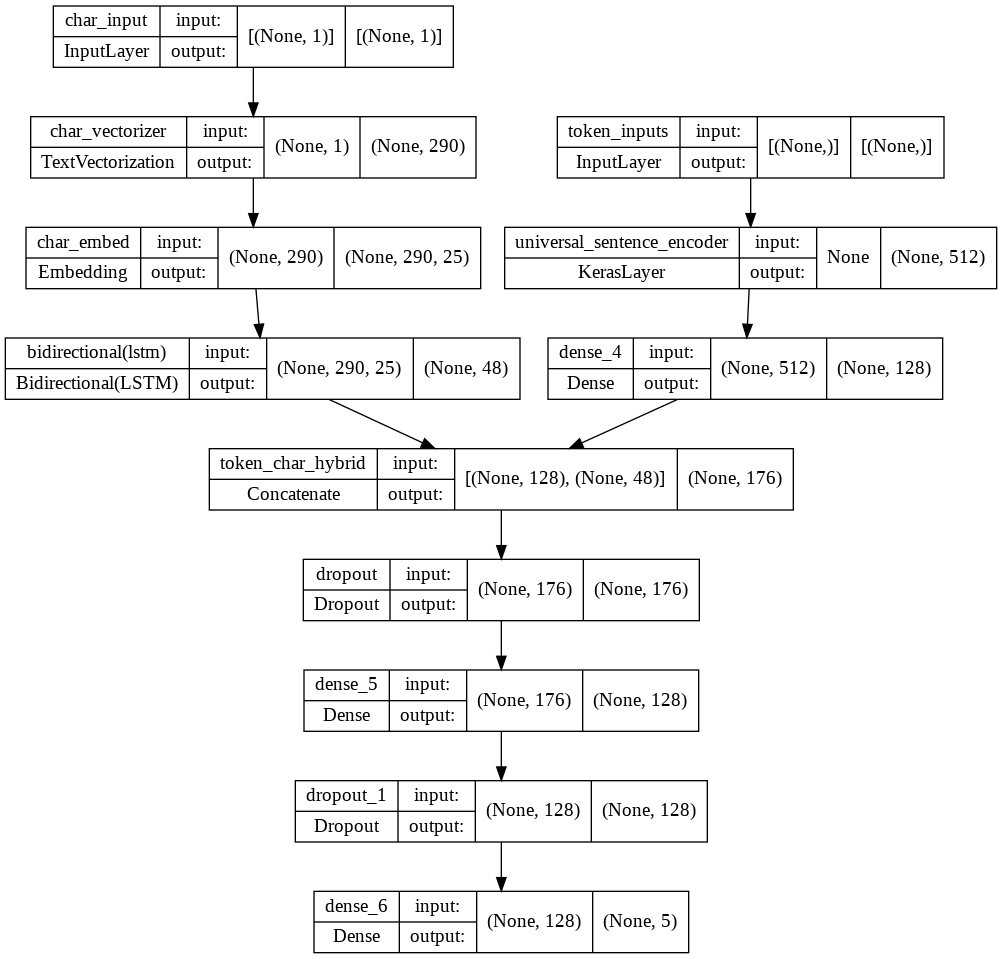

In [80]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [81]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

### Combining token and character data into a tf.data Dataset

In [82]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))  # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)  # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))    # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [83]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))  # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)  # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))    # combine data and labels

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [84]:
# Same with the test data
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))  # make data
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)  # make labels
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))    # combine data and labels

test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [85]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset, test_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [86]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                            #   steps_per_epoch=len(train_char_token_dataset),
                              epochs=5,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/5
562/562 [==============================] - 39s 52ms/step - loss: 0.9766 - accuracy: 0.6140 - val_loss: 0.7759 - val_accuracy: 0.7031
Epoch 2/5
562/562 [==============================] - 26s 47ms/step - loss: 0.7999 - accuracy: 0.6901 - val_loss: 0.7163 - val_accuracy: 0.7211
Epoch 3/5
562/562 [==============================] - 24s 42ms/step - loss: 0.7708 - accuracy: 0.7029 - val_loss: 0.6887 - val_accuracy: 0.7404
Epoch 4/5
562/562 [==============================] - 28s 49ms/step - loss: 0.7397 - accuracy: 0.7224 - val_loss: 0.6646 - val_accuracy: 0.7473
Epoch 5/5
562/562 [==============================] - 25s 44ms/step - loss: 0.7446 - accuracy: 0.7180 - val_loss: 0.6552 - val_accuracy: 0.7510


In [87]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 22s 23ms/step - loss: 0.6606 - accuracy: 0.7481


[0.6606343388557434, 0.7481133341789246]

In [88]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[5.3855205e-01, 2.3840253e-01, 8.1333434e-03, 1.9964804e-01,
        1.5264059e-02],
       [4.6563789e-01, 3.8516444e-01, 1.3930871e-02, 1.3034047e-01,
        4.9263542e-03],
       [2.7521107e-01, 3.2370638e-02, 4.5387071e-02, 6.3507652e-01,
        1.1954746e-02],
       ...,
       [2.8551696e-04, 1.4033722e-03, 3.3961434e-02, 1.2534247e-04,
        9.6422434e-01],
       [4.8734811e-03, 2.0761907e-02, 4.4917503e-01, 2.7175890e-03,
        5.2247196e-01],
       [2.5417379e-01, 4.0754873e-01, 2.6794383e-01, 7.5483737e-03,
        6.2785290e-02]], dtype=float32)

In [89]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [90]:
# Calculate results of token-char hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 74.81133324506818,
 'f1': 0.742423254427983,
 'precision': 0.7440325127396423,
 'recall': 0.7481133324506819}

## Model 5: Transfer Learning with Pretrained Token Embeddings + Character Embeddings + Positional Embeddings

In [91]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> **🔑 Note:** Any engineered features used to train a model must be available at test time. In our case, line numbers and total lines are available.

### Create Positional Embeddings

In [92]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

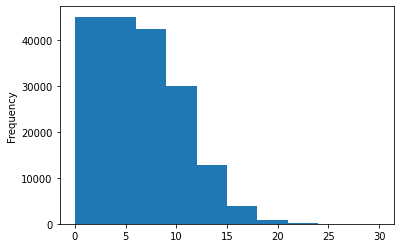

In [93]:
# Check the distribution of "line_number" column
train_df["line_number"].plot.hist();

In [94]:
# Use TensorFlow to create one-hot encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot[:13], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(13, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([1

Now we've encoded our line number feature, let's do the same for our total lines feature...

In [95]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

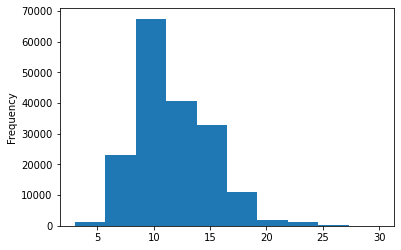

In [96]:
# Check the distribution of "total_lines" column
train_df["total_lines"].plot.hist();

In [97]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df["total_lines"], 98)

20.0

In [98]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot[:13], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(13, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using `tf.keras.layers.Concatenate`
6. Combine the outputs of 3, 4 & 5 using `tf.keras.layers.Concatenate`
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a `tf.keras.Model`

In [99]:
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Concatenate, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

# 1. Token inputs
token_inputs = Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = Dense(128, activation="relu")(token_embeddings)
token_model = Model(inputs=token_inputs, 
                    outputs=token_outputs)

# 2. Char inputs
char_inputs = Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = Bidirectional(LSTM(24))(char_embeddings)
char_model = Model(inputs=char_inputs, 
                   outputs=char_bi_lstm)

# 3. Line numbers model
# inputs, shape = ?
line_numbers_inputs = Input(shape=(15,), dtype=tf.float32, name="line_number_inputs")
# dense layer with 32 units & relu activation
x = Dense(32, activation="relu")(line_numbers_inputs)
# combine inputs & dense layer into model
line_numbers_model = Model(inputs=line_numbers_inputs, 
                           outputs=x)

# 4. Total lines
# inputs, shape = ?
total_lines_inputs = Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")
# dense layer with 32 units & relu activation
y = Dense(32, activation="relu")(total_lines_inputs)
# combine inputs & dense layer into model
total_lines_model = Model(inputs=total_lines_inputs, 
                          outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                       char_model.output])
z = Dense(256, activation="relu")(combined_embeddings)
z = Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = Concatenate(name="char_token_positional_embedding")([line_numbers_model.output,
                                                                          total_lines_model.output,
                                                                          z])

# 7. Create output layer
output_layer = Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of outputs
model_5 = Model(inputs=[line_numbers_model.input,
                        total_lines_model.input,
                        token_model.input,
                        char_model.input],
                outputs=output_layer,
                name="model_5_tribrid_embedding_model")

In [100]:
# Get a summary of our tribrid embedding model
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

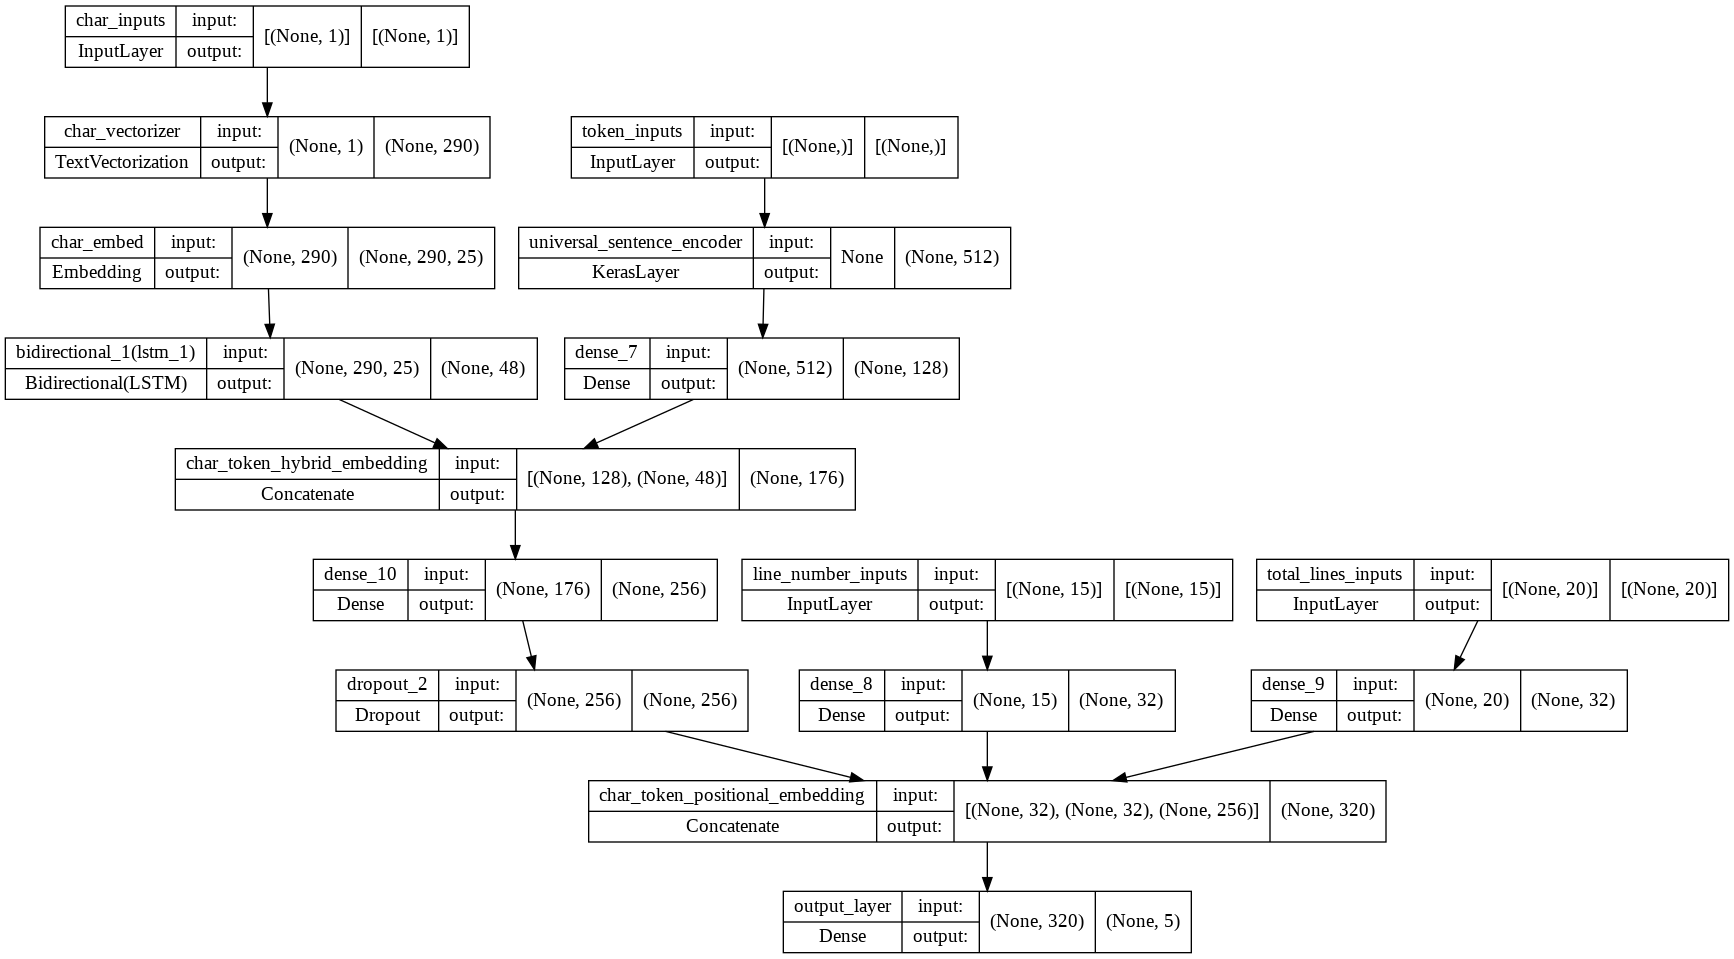

In [101]:
# Plot model_5 to explore it visually
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

What is label smoothing?

For example, if our model gets too confident on a single class (e.g. it's prediction probability is really high), iy may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`

> 📖 **Resource:** For more on label smoothing, see this [blog post](https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/) from PyImageSearch


In [102]:
# Compile token, char and postional embedding model
from tensorflow.keras.losses import CategoricalCrossentropy

model_5.compile(loss=CategoricalCrossentropy(label_smoothing=0.2),  # helps to prevent overfitting
                optimizer=Adam(),
                metrics=["accuracy"])

### Create tribing embedding datasets from `tf.data`

In [103]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [104]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predictions with our tribrid model

In [105]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                            #   steps_per_epoch=len(train_char_token_pos_dataset),
                              epochs=5,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/5
562/562 [==============================] - 37s 52ms/step - loss: 1.0947 - accuracy: 0.7254 - val_loss: 0.9843 - val_accuracy: 0.7989
Epoch 2/5
562/562 [==============================] - 30s 53ms/step - loss: 0.9684 - accuracy: 0.8126 - val_loss: 0.9482 - val_accuracy: 0.8238
Epoch 3/5
562/562 [==============================] - 30s 53ms/step - loss: 0.9487 - accuracy: 0.8230 - val_loss: 0.9383 - val_accuracy: 0.8295
Epoch 4/5
562/562 [==============================] - 29s 51ms/step - loss: 0.9396 - accuracy: 0.8349 - val_loss: 0.9284 - val_accuracy: 0.8354
Epoch 5/5
562/562 [==============================] - 25s 45ms/step - loss: 0.9356 - accuracy: 0.8353 - val_loss: 0.9217 - val_accuracy: 0.8451


In [106]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 28s 26ms/step


array([[0.6192626 , 0.09008696, 0.01463523, 0.25603375, 0.01998152],
       [0.60746765, 0.0702934 , 0.08187165, 0.22378542, 0.01658187],
       [0.3879328 , 0.09259851, 0.1310176 , 0.3365186 , 0.05193248],
       ...,
       [0.03299725, 0.06774169, 0.0459345 , 0.02643333, 0.82689315],
       [0.02252535, 0.30199534, 0.11773191, 0.01874423, 0.53900313],
       [0.1213949 , 0.6843991 , 0.07470228, 0.02286426, 0.09663945]],
      dtype=float32)

In [107]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1])>

In [108]:
# Calculate results of char token pos model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 84.32741956838342,
 'f1': 0.8396919869139082,
 'precision': 0.8457162417010564,
 'recall': 0.8432741956838342}

## Compare model results

In [109]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,81.957500,0.821139,0.819575,0.817375
model_2_pretrained_token_embedding,73.384748,0.729588,0.733847,0.728075
model_3_custom_char_embedding,67.933272,0.685315,0.679333,0.676704
model_4_hybrid_char_token_embedding,74.811333,0.744033,0.748113,0.742423
model_5_pos_char_token_embedding,84.327420,0.845716,0.843274,0.839692


In [110]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"] / 100

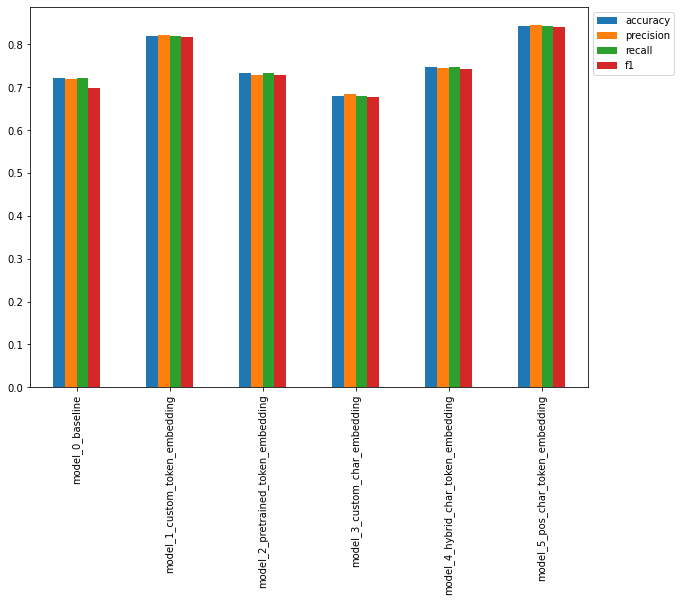

In [111]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

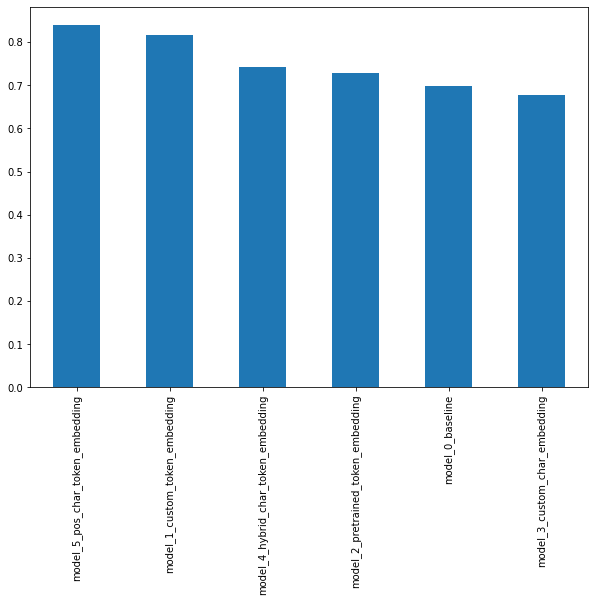

In [112]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Save and load best performing model

In [113]:
# Save best performing model to SavedModel format (default)
model_5.save("skimlit_tribrid_model") 

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


In [114]:
# Load in the saved best-performing model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

## Make predictions with loaded model and compare with original model

In [115]:
# Make predictions with the loaded model on the validation set
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 2, 2, 4, 4, 4, 4, 1])>

In [116]:
# Calculate results of loaded model
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 84.32741956838342,
 'f1': 0.8396919869139082,
 'precision': 0.8457162417010564,
 'recall': 0.8432741956838342}

In [117]:
# Compare loaded model results with original trained model results (should be quite close)
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()))

array([ True,  True,  True,  True])

In [118]:
# Check a summary of loaded model to see number of trainable params
loaded_model.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

## Evaluate model on test dataset

In [119]:
# Create test dataset batch and prefetched
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_char_token_pos_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [120]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_char_token_pos_dataset,)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 4, 2, 1, 1, 0])>

In [121]:
# Calculate results of loaded model on test data
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 83.90575742492119,
 'f1': 0.8353601468097303,
 'precision': 0.8406193284115853,
 'recall': 0.8390575742492119}

### Find most wrong predictions

In [122]:
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes[:10]

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND']

In [123]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.420635,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,METHODS,0.448972,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.845476,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.850003,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.701955,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.841913,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,METHODS,0.453534,False
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.424609,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.536527,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.620423,True


In [124]:
# Find top 20 most wrong samples
top_20_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:20]
top_20_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.965200,False
3573,RESULTS,a cluster randomised trial was implemented wit...,3,16,METHODS,0.944165,False
29294,RESULTS,"baseline measures included sociodemographics ,...",4,13,METHODS,0.941446,False
6027,RESULTS,patients were randomized in a bayesian respons...,4,15,METHODS,0.939206,False
18720,RESULTS,non-diffuse-trickling '' ) .,8,15,BACKGROUND,0.936412,False
22375,RESULTS,patients were randomly assigned to receive eit...,4,12,METHODS,0.933286,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.922540,False
15697,RESULTS,family practices were randomly assigned to rec...,3,11,METHODS,0.922375,False
8527,OBJECTIVE,participants were randomly allocated to a trea...,2,10,METHODS,0.920788,False
920,RESULTS,"@,@ infants aged @-@ wk and @,@ children aged ...",2,14,METHODS,0.919070,False


In [125]:
# Investigate top wrong preds
for row in top_20_wrong[:10].itertuples(): 
    _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
    print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
    print(f"Text:\n{text}\n")
    print("-----\n")

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9651995301246643, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9441646933555603, Line number: 3, Total lines: 16

Text:
a cluster randomised trial was implemented with @,@ children in @ government primary schools on the south coast of kenya in @-@ .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9414457082748413, Line number: 4, Total lines: 13

Text:
baseline measures included sociodemographics , standardized anthropometrics , asthma control test ( act ) , gerd symptom assessment scale , pittsburgh sleep quality index , and berlin questionnaire for sleep apnea .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9392056465148926, Line number: 4, Total lines: 15

Text:
patients were randomized in a bayesian response-adaptive design to receive intravenous decitabine @ mg/m ( @ ) daily for @ days or decitabine plus oral valproic a

## Make example predictions

In [126]:
# Download and open example abstracts
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

import json

with open("skimlit_example_abstracts.json", "r") as f:
    example_abstracts = json.load(f)

example_abstracts

--2022-06-21 14:11:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2022-06-21 14:11:41 (89.4 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'details': 'RCT of a manualized social treatment for high-functioning autism spectrum 

In [127]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [128]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd 
from spacy.lang.en import English
nlp = English() # setup English sentence parser
nlp.add_pipe("sentencizer") # add sentence splitting pipeline object to sentence parser
doc = nlp(example_abstracts[0]["abstract"]) # create "doc" of parsed sequences, change index for a different abstract
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [129]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
    sample_dict = {}
    sample_dict["text"] = str(line)
    sample_dict["line_number"] = i
    sample_dict["total_lines"] = total_lines_in_sample - 1
    sample_lines.append(sample_dict)
    
sample_lines

[{'line_number': 0,
  'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'total_lines': 7},
 {'line_number': 1,
  'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'total_lines': 7},
 {'line_number': 2,
  'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'total_lines': 7},
 {'line_number': 3,
  'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'total_lines': 7},
 {'line_number': 4,
  'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'total_lines': 7},
 {'line_number': 5,
  'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'total_lines': 7},
 {'line_

In [130]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]

In [131]:
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [132]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]

In [133]:
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [134]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [135]:
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

array([[0.38373226, 0.09760564, 0.02649583, 0.45101222, 0.04115406],
       [0.07177788, 0.0332805 , 0.7460445 , 0.08627529, 0.06262181],
       [0.07906543, 0.03895743, 0.7351828 , 0.10274205, 0.0440522 ],
       [0.11004119, 0.15528983, 0.5496015 , 0.06400549, 0.12106195],
       [0.05126262, 0.10271973, 0.4680301 , 0.04536957, 0.33261806],
       [0.04114959, 0.10926622, 0.50822204, 0.05166992, 0.28969225],
       [0.02315752, 0.21180469, 0.1012026 , 0.02335618, 0.640479  ],
       [0.01636014, 0.12560064, 0.21723616, 0.03031052, 0.6104926 ]],
      dtype=float32)

In [136]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [137]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [138]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
    print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


Nice! Isn't that much easier to read? I mean, it looks like our model's predictions could be improved, but how cool is that?